Tester for multiple sources

In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
from core import pds
import numpy as np
from datetime import timedelta

In [2]:
# pds frame definition
pds1d_frame = pds.PDS1D_MultiSource()

In [3]:
# setup mesh
nx = 100
dx = 1
x = np.arange(0, nx * dx, dx)

d = 2
u_init = np.zeros(nx)
t0 = 0
lbc = 'Neumann'
rbc = 'Neumann'

In [4]:
# Load test data
from DSS_analyzer_Mariner import Data1D_GAUGE
test_gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE('testdata/pressure_gauge_data.npz')

from DSS_analyzer_Mariner import Data1D_PumpingCurve
stage4_pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve('testdata/pumping_curve_stage4.npz')
stage5_pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve('testdata/pumping_curve_stage5.npz')

In [5]:
# Crop the gauge data into three parts
start_time_stg4 = stage4_pumping_curve_dataframe.get_start_time()
end_time_stg4 = stage4_pumping_curve_dataframe.get_end_time()

start_time_stg5 = stage5_pumping_curve_dataframe.get_start_time()
end_time_stg5 = stage5_pumping_curve_dataframe.get_end_time()

In [6]:
stg4_pg_dataframe = test_gauge_dataframe.copy()
stg4_pg_dataframe.crop(start_time_stg4, end_time_stg4)

In [7]:
interval_pg_dataframe = test_gauge_dataframe.copy()
interval_pg_dataframe.crop(end_time_stg4, start_time_stg5)

In [8]:
stg5_pg_dataframe = test_gauge_dataframe.copy()
stg5_pg_dataframe.crop(start_time_stg5, end_time_stg5)

In [9]:
# pass the parameters
pds1d_frame.set_mesh(x)
pds1d_frame.set_diffusivity(d)
pds1d_frame.set_bcs(lbc, rbc)
pds1d_frame.set_t0(t0)

Diffusivity is a single scalar value, broadcasted to the mesh length.


In [10]:
# Set the source index. This time we have 3 sources. This time will not use finner mesh.
from core import mesh_utils

source_idx_1, x_val = mesh_utils.locate(x, 45)
source_idx_2, x_val = mesh_utils.locate(x, 55)
source_idx_3, x_val = mesh_utils.locate(x, 65)

In [11]:
# pass the parameters to pds1d_frame
pds1d_frame.set_sourceidx([source_idx_1, source_idx_2, source_idx_3])

In [12]:
pds1d_frame.sourceidx.shape

(3,)

TEST -> PASS

In [13]:
# Set sources, I will use the same source for all the sources
total_simulation_time = 1000

In [14]:
# For the test purpose, crop the gauge data
test_gauge_dataframe = stg4_pg_dataframe.copy()
# decide the time range
test_start_time = start_time_stg4 + timedelta(seconds = 200)
test_end_time = test_start_time + timedelta(seconds = total_simulation_time)
test_gauge_dataframe.crop(test_start_time, test_end_time)

In [15]:
test_source = [test_gauge_dataframe, test_gauge_dataframe, test_gauge_dataframe]

In [16]:
pds1d_frame.set_source(test_source)

In [17]:
pds1d_frame.print_log()

Mesh is properly set.
Diffusivity is properly set.
Boundary conditions are properly set.
Initial time set done. 
The simulation starts at 0.
Source index is properly set.
Source term is properly set.


In [18]:
len(pds1d_frame.source)

3

TEST -> PASS

In [19]:
u_init[:] =  test_gauge_dataframe.data[0]
pds1d_frame.set_initial(u_init)

Start the simulation with the initial condition

In [20]:
# test reset func
pds1d_frame.reset()

In [21]:
pds1d_frame.print()

         PDS1D_SingleSource Info         
           mesh: shape=(100,), unique=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
         source: [<DSS_analyzer_Mariner.Data1D_GAUGE.Data1D_GAUGE object at 0x12d645370>, <DSS_analyzer_Mariner.Data1D_GAUGE.Data1D_GAUGE object at 0x12d645370>, <DSS_analyzer_Mariner.Data1D_GAUGE.Data1D_GAUGE object at 0x12d645370>]
            lbc: Neumann
            rbc: Neumann
        initial: shape=(100,), unique=[9339.266]
    diffusivity: shape=(100,), unique=[2]
             t0: 0
          taxis: None
      sourceidx: shape=(3,), unique=[45 55 65]
       snapshot: None
        history: []


# Core function test

In [22]:
# Test snapshot
pds1d_frame.solve(optimizer= False, dt = 5, t_total= total_simulation_time, print_progress=False)

Time array generated using t_total.
Problem solved.


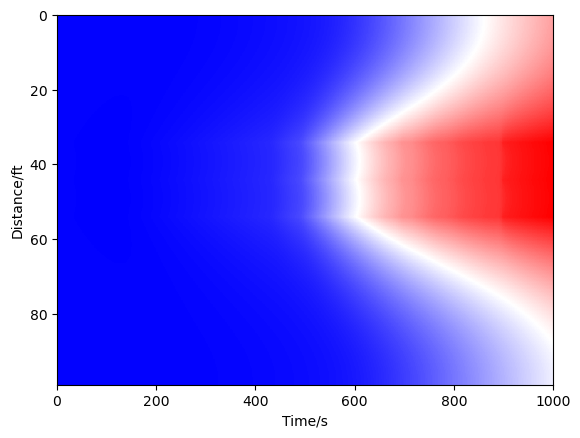

In [23]:
pds1d_frame.plot_solution(method='imshow')

TEST -> PASS

Then, we will test the optimizer

# Optimizer test

In [24]:
pds1d_frame.reset()

In [25]:
pds1d_frame.solve(optimizer= True, dt_init = 2, t_total= total_simulation_time, print_progress=False,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using t_total.
Problem solved.


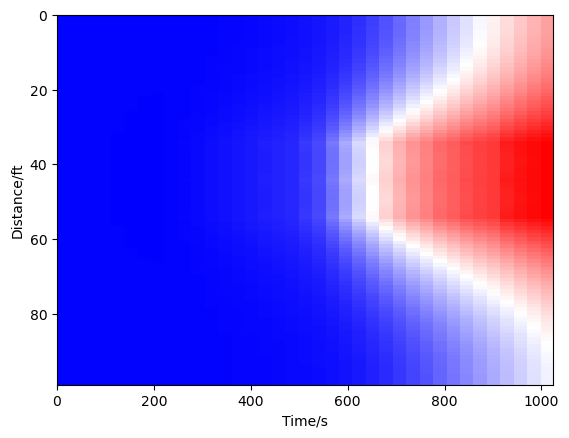

In [26]:
pds1d_frame.plot_solution(method='imshow')

TEST -> PASS

# Inhomogeneous gridding strategy test

In [27]:
pds1d_frame.reset()

In [28]:
# Update mesh related parameters
x = mesh_utils.refine_mesh(x, [70, 80], 10)
nx = len(x)

In [29]:
u_init = np.zeros(nx)
t0 = 0

In [30]:
pds1d_frame.set_mesh(x)
pds1d_frame.set_initial(u_init)

In [31]:
# Update the source index
source_idx_1, x_val = mesh_utils.locate(x, 45)
source_idx_2, x_val = mesh_utils.locate(x, 55)
source_idx_3, x_val = mesh_utils.locate(x, 65)

In [32]:
pds1d_frame.set_sourceidx([source_idx_1, source_idx_2, source_idx_3])

In [33]:
pds1d_frame.print_log()

Mesh is properly set.
Initial condition is properly set.
Source index is properly set.


In [34]:
u_init[:] =  test_gauge_dataframe.data[0]
pds1d_frame.set_initial(u_init)

In [36]:
# Update the diffusion coefficient
d = 2
pds1d_frame.set_diffusivity(d)

Diffusivity is a single scalar value, broadcasted to the mesh length.


In [37]:
pds1d_frame.solve(optimizer= False, dt = 5, t_total= total_simulation_time, print_progress=False)

Time array generated using t_total.
Problem solved.


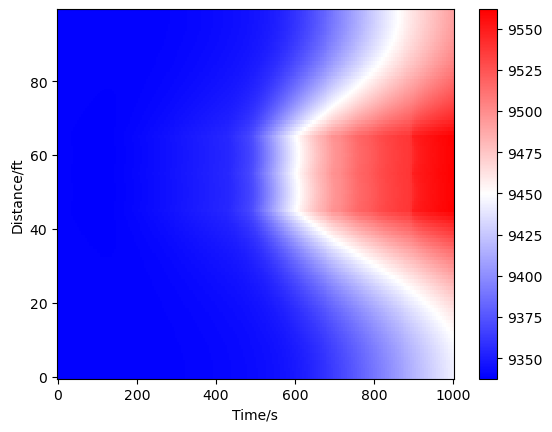

In [38]:
pds1d_frame.plot_solution(method='pcolormesh')

In [39]:
# Test optimizer
pds1d_frame.reset()

In [40]:
pds1d_frame.solve(optimizer= True, dt_init = 2, t_total= total_simulation_time, print_progress=False,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using t_total.
Problem solved.


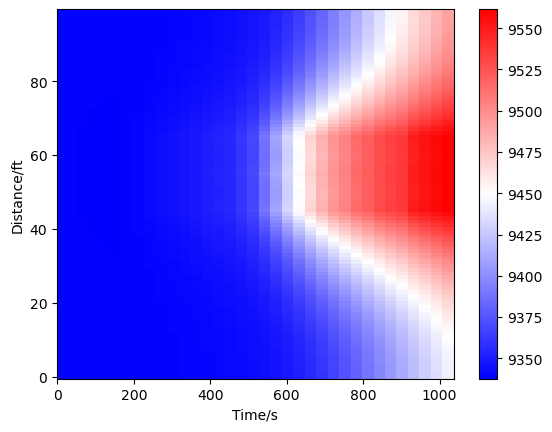

In [41]:
pds1d_frame.plot_solution(method='pcolormesh')

TEST -> PASS.
All tests passed.